<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/paper-examples/1-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [1]:
%matplotlib inline

!pip install deeptrack tensorflow_datasets

# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

We can download the images to your disk using the Python package \texttt{deeptrack}:

In [1]:
import sys 
sys.path.insert(0, '../../..')
import deeptrack as dt
from deeptrack import TensorflowDataset


c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# import tensorflow_datasets as tfds
dataset = TensorflowDataset("malaria", split="train[:80%]", shuffle_files=True, keys=["image", "label"])

# separate into images and labels
image_pipeline = dataset.image
label_pipeline = dataset.label

print("Size:", dataset.size)

Size: 22046


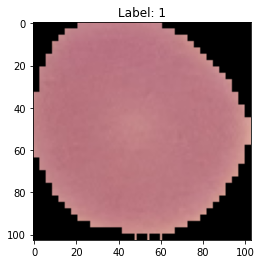

In [3]:
import matplotlib.pyplot as plt

dataset.update()
image = image_pipeline()
label = label_pipeline()
plt.title(f"Label: {label}")
plt.imshow(image)
plt.show()


In [4]:
preprocessing = (
    dt.NormalizeMinMax(0, 1)
)

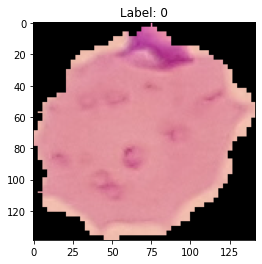

In [6]:
processed_image_pipeline = image_pipeline >> preprocessing

processed_image_pipeline.update()
processed_image = processed_image_pipeline()
label = label_pipeline()
plt.title(f"Label: {label}")
plt.imshow(processed_image)
plt.show()

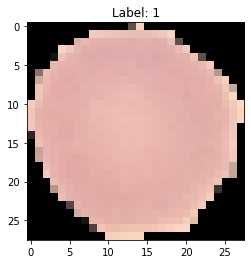

In [7]:
preprocessing = (
    dt.NormalizeMinMax(0, 1) >>
    dt.Resize((28, 28))
)

processed_image_pipeline = image_pipeline >> preprocessing

processed_image_pipeline.update()
processed_image = processed_image_pipeline()
label = label_pipeline()
plt.title(f"Label: {label}")
plt.imshow(processed_image)
plt.show()

In [8]:
validation_dataset = TensorflowDataset("malaria", split="train[80%:]", shuffle_files=True, keys=["image", "label"])

validation_image_pipeline = validation_dataset.image
validation_label_pipeline = validation_dataset.label

validation_pipeline = (
    (validation_image_pipeline >> preprocessing)
    & validation_label_pipeline
)

from numpy import array

validation_data = []
validation_labels = []
for i in range(validation_dataset.size):
    validation_pipeline.update()
    image, label = validation_pipeline()
    validation_data.append(image)
    validation_labels.append(label)

validation_data = array(validation_data)
validation_labels = array(validation_labels)

In [10]:
from deeptrack.models import FullyConnected
from deeptrack.layers import DenseBlock


model = FullyConnected(
    input_shape=(28, 28, 3,),
    dense_layers_dimensions=(128, 128, 128),
    number_of_outputs=1,
    output_activation="sigmoid",
    dense_block=DenseBlock(activation="sigmoid")
)
model.summary()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
model.compile(
    loss="mse",
    optimizer=RMSprop(learning_rate=0.001),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)


h = model.fit(
    processed_image_pipeline & label_pipeline,
    epochs=100,
    batch_size=32,
    generator_kwargs={
        "min_data_size": 2000,
        "max_data_size": 4000,
        "max_epochs_per_sample": 50,
    }
)

loss, accuracy, precision, recall = model.evaluate(validation_data, validation_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 1000)              2353000   
                                                                 
 activation (Activation)     (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 activation_1 (Activation)   (None, 500)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               125250

In [92]:
from deeptrack.models import Convolutional
from deeptrack.layers import DenseBlock


model = Convolutional(
    input_shape=(28, 28, 3,),
    conv_layers_dimensions=(32, 64, 128),
    dense_layers_dimensions=(64, 64),
    number_of_outputs=1,
    output_activation="sigmoid",
)
model.summary()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
model.compile(
    loss="mse",
    optimizer=RMSprop(learning_rate=0.001),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)


h = model.fit(
    processed_image_pipeline & label_pipeline,
    epochs=20,
    batch_size=32,
    generator_kwargs={
        "min_data_size": 5000,
        "max_data_size": dataset.size,
    },
    validation_data=(validation_data, validation_labels)
)


loss, accuracy, precision, recall = model.evaluate(validation_data, validation_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 activation_77 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 activation_78 (Activation)  (None, 14, 14, 64)        0         
                                                          

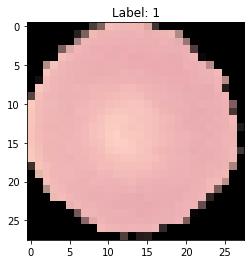

In [70]:
from deeptrack.models import Convolutional
from deeptrack.layers import DenseBlock
from numpy.random import uniform
from numpy import pi

preprocessing = (
    dt.NormalizeMinMax(0, 1) >>
    dt.Resize((28, 28))
)

augmentation = (
    dt.FlipLR(p=0.5)>>
    dt.Affine(
        rotate=lambda: uniform(0, 2*pi),
        translate=lambda: uniform(-3, 3, size=2),
        mode="constant",
    )
)

processed_image_pipeline = image_pipeline >> augmentation >> preprocessing

processed_image_pipeline.update()
processed_image = processed_image_pipeline()
label = label_pipeline()
plt.title(f"Label: {label}")
plt.imshow(processed_image)
plt.show()

In [73]:


model = Convolutional(
    input_shape=(28, 28, 3,),
    conv_layers_dimensions=(32, 64, 128),
    dense_layers_dimensions=(64, 64),
    number_of_outputs=1,
    output_activation="sigmoid",
)
model.summary()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
model.compile(
    loss="mse",
    optimizer=RMSprop(learning_rate=0.001),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)


h = model.fit(
    processed_image_pipeline & label_pipeline,
    epochs=20,
    batch_size=32,
    generator_kwargs={
        "min_data_size": 5000,
        "max_data_size": dataset.size,
    },
)


loss, accuracy, precision, recall = model.evaluate(validation_data, validation_labels)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 activation_32 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 activation_33 (Activation)  (None, 14, 14, 64)        0         
                                                           

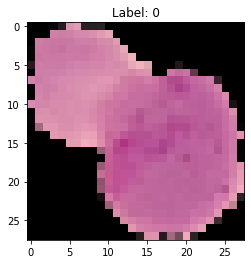

In [87]:
preprocessing = (
    dt.NormalizeMinMax(0, 1) >>
    dt.Resize((28, 28))
)

augmentation = (
    dt.FlipLR(p=0.5)>>
    dt.FlipUD(p=0.5)>>
    dt.FlipDiagonal(p=0.5)
)

processed_image_pipeline = image_pipeline >> preprocessing >> augmentation

processed_image_pipeline.update()
processed_image = processed_image_pipeline()
label = label_pipeline()
plt.title(f"Label: {label}")
plt.imshow(processed_image)
plt.show()

In [81]:
validation_dataset = TensorflowDataset("malaria", split="train[80%:]", shuffle_files=True, keys=["image", "label"])

validation_image_pipeline = validation_dataset.image
validation_label_pipeline = validation_dataset.label

validation_pipeline = (
    (validation_image_pipeline >> preprocessing)
    & validation_label_pipeline
)

from numpy import array

validation_data = []
validation_labels = []
for i in range(validation_dataset.size):
    validation_pipeline.update()
    image, label = validation_pipeline()
    validation_data.append(image)
    validation_labels.append(label)

validation_data = array(validation_data)
validation_labels = array(validation_labels)

In [14]:
model = Convolutional(
    input_shape=(28, 28, 3,),
    conv_layers_dimensions=(64, 128),
    steps_per_pooling=2,
    dense_layers_dimensions=(64, 64),
    number_of_outputs=1,
    flatten_method="flatten",
    output_activation="sigmoid",
)
model.summary()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
model.compile(
    loss="mse",
    optimizer=RMSprop(learning_rate=0.001),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)


h = model.fit(
    processed_image_pipeline & label_pipeline,
    epochs=20,
    batch_size=32,
    generator_kwargs={
        "min_data_size": 5000,
        "max_data_size": dataset.size,
    },
)

loss, accuracy, precision, recall = model.evaluate(validation_data, validation_labels)
print(f"MSE: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 activation_16 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 activation_17 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                           

In [17]:
from deeptrack.models import Convolutional

model = Convolutional(
    input_shape=(28, 28, 3),
    conv_layers_dimensions=(64, 128),
    steps_per_pooling=2,
    dense_layers_dimensions=(64, 64),
    number_of_outputs=1,
    flatten_method="global_max",
    output_activation="sigmoid",
)
model.summary()

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
model.compile(
    loss="mse",
    optimizer=RMSprop(learning_rate=0.001),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)


h = model.fit(
    processed_image_pipeline & label_pipeline,
    epochs=20,
    batch_size=32,
    generator_kwargs={
        "min_data_size": 5000,
        "max_data_size": dataset.size,
    },
)

loss, accuracy, precision, recall = model.evaluate(validation_data, validation_labels)
print(f"MSE: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 activation_36 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 activation_37 (Activation)  (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                           